# Linear Regression for Cell State

In [3]:
from pathlib import Path
import os
import warnings
from typing import Optional, List, Tuple, Dict

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 150

In [5]:
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [6]:
# Running from ml_drought
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

In [7]:
import sys
sys.path.insert(1, '/home/tommy/neuralhydrology')

from neuralhydrology.modelzoo.ealstm import EALSTM
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.datasetzoo.camelsgb import CamelsGB
from neuralhydrology.datautils.utils import load_basin_file
from neuralhydrology.utils.config import Config
from neuralhydrology.utils.errors import NoTrainDataError
from neuralhydrology.training.train import BaseTrainer

In [8]:
run_dir = data_dir / "runs/ensemble_EALSTM/ealstm_ensemble6_nse_1998_2008_2910_030601"

# Config file
config_path = (run_dir / "config.yml") 
config = Config(config_path)

# Load all data

In [9]:
# read in the training data
dynamic = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
dynamic['station_id'] = dynamic['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

In [10]:
cs_data = xr.open_dataset(data_dir / "RUNOFF/cs_data.nc")

# Load SM

In [ ]:
sm_csvs = [
    (
        pd.read_table(d, sep=";", decimal=",")
        .drop("Unnamed: 0", axis=1)
        .rename({"Date": "time"}, axis=1)
        .set_index("time")
        .astype("float64")
    )
    for d in (data_dir / "RUNOFF/sm_data").glob("*Level*.csv")
]

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
obs_sm = pd.read_table(data_dir / "RUNOFF/Soil_Moisture_Catchments.csv", sep=";", decimal=",").drop("Unnamed: 0", axis=1)
obs_sm.head()

,Date,10002,10003,1001,101002,101005,102001,106001,107001,11001,...,9004,9005,92001,93001,94001,95001,96001,96002,96004,97002
0,2000-01-01,0.337877,0.381631,0.506113,NaN,NaN,0.397686,0.730406,NaN,0.353741,...,0.298484,0.306041,0.723135,0.716671,NaN,0.522572,0.725148,0.714350,0.476457,0.622826
1,2000-01-02,0.332717,0.377669,0.513014,NaN,NaN,0.388705,0.734120,NaN,0.353997,...,0.297326,0.307413,0.719752,0.709693,NaN,0.515382,0.733922,0.708342,0.473973,0.630514
2,2000-01-03,0.324421,0.370437,0.502599,NaN,NaN,0.402999,0.730592,NaN,0.349091,...,0.291302,0.300950,0.715811,0.711207,NaN,0.500618,0.718131,0.698553,0.459574,0.617390
3,2000-01-04,0.320845,0.366019,0.499462,NaN,NaN,0.404920,0.731137,NaN,0.341477,...,0.282174,0.288874,0.718646,0.693217,NaN,0.490456,0.714536,0.687420,0.449786,0.614374
4,2000-01-05,0.322252,0.369935,0.501533,NaN,NaN,0.397324,0.752046,NaN,0.352938,...,0.292348,0.303006,0.731672,0.713501,NaN,0.518180,0.722849,0.705080,0.469912,0.619883


In [13]:
sm_df = obs_sm.set_index("Date").stack().reset_index().rename({0: "soil_moisture", "level_1": "station_id", "Date": "time"}, axis=1)
sm_df["time"] = pd.to_datetime(sm_df["time"])
sm_df = sm_df.sort_values(["station_id", "time"]).set_index(["time", "station_id"])
sm = sm_df.to_xarray()
sm_df.head()

,,soil_moisture
time,station_id,
2000-01-01,10002,0.337877
2000-01-02,10002,0.332717
2000-01-03,10002,0.324421
2000-01-04,10002,0.320845
2000-01-05,10002,0.322252


In [14]:
# NORMALIZE SM
def normalize_dataframe_by_basin(df: pd.DataFrame):
    assert all(np.isin(["time", "station_id"], df.reset_index().columns))
    scaler = StandardScaler()
    norm_ = df.groupby("station_id").apply(lambda x: scaler.fit_transform(x).flatten())

    norm_df = norm_.explode().reset_index().rename({0: "norm"}, axis=1)
    norm_df["time"] = df.reset_index().sort_values(["station_id", "time"])["time"]
    norm_df = norm_df.set_index(["station_id", "time"])
    
    return  norm_df

In [15]:
norm_df = normalize_dataframe_by_basin(sm_df)
norm_df.head()

norm
station_id time                
10002      2000-01-01  0.576624
           2000-01-02  0.484179
           2000-01-03   0.33553
           2000-01-04  0.271458
           2000-01-05   0.29668

# Linear Regression

In [16]:
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from typing import DefaultDict

In [17]:
# input_data = cs_data
input_data = cs_data.groupby("time").mean()
target_data = dynamic["discharge_spec"]
target_data = norm_df.to_xarray()["norm"]
input_data["station_id"] = [int(sid) for sid in input_data["station_id"]] 

In [39]:
target_data = norm_df.to_xarray()["norm"]
target_data["station_id"] = [int(sid) for sid in target_data["station_id"]] 

In [89]:
from typing import Any
import torch

class CellStateDataset(Dataset):
    def __init__(self, input_data: xr.Dataset, target_data: xr.DataArray, config, mean: bool = True):
        assert all(np.isin(["time", "dimension", "station_id"], input_data.dims))
        assert "cell_state" in input_data
        assert all(np.isin(input_data.station_id.values, target_data.station_id.values))
        
        self.input_data = input_data

        # test times
        test_times = pd.date_range(config.test_start_date, config.test_end_date, freq="D")
        test_times = pd.date_range(config.test_start_date, config.test_end_date, freq="D")
        bool_input_times = np.isin(input_data.time.values, test_times)
        bool_target_times = np.isin(target_data.time.values, test_times)
        self.test_times = list(
            set(target_data.time.values[bool_target_times]).intersection(
                set(input_data.time.values[bool_input_times])
            )
        )

        # get input/target data
        self.input_data = self.input_data.sel(time=self.test_times)
        self.target_data = target_data.sel(time=self.test_times)
        
        # basins
        self.basins = input_data.station_id.values
        
        # dimensions
        self.dimensions = len(input_data.dimension.values)
        
        # create x y pairs
        self.create_samples()
            
    def __len__(self):
        return len(self.samples)
    
    def create_samples(self):
        self.samples = []
        self.basin_samples = []
        self.time_samples = []
        
        for basin in self.basins:
            # read the basin data
            X = self.input_data["cell_state"].sel(station_id=basin).values.astype("float64")
            Y = self.target_data.sel(station_id=basin).values.astype("float64")
            
            finite_indices = np.logical_and(np.isfinite(Y), np.isfinite(X).all(axis=1))
            X, Y = X[finite_indices], Y[finite_indices]
            times = self.input_data["time"].values[finite_indices].astype(float)

            # convert to Tensors
            X = torch.from_numpy(X).float().to("cuda:0")
            Y = torch.from_numpy(Y).float().to("cuda:0")
            
            
            # create unique samples [(64,), (1,)]
            samples = [(x, y.reshape(-1)) for (x, y) in zip(X, Y)]
            self.samples.extend(samples)
            self.basin_samples.extend([basin for _ in range(len(samples))])
            self.time_samples.extend(times)
        

    def __getitem__(self, item: int) -> Tuple[Tuple[str, Any], Tuple[torch.Tensor]]:
        basin = str(self.basin_samples[item])
        time = self.time_samples[item]
        x, y = self.samples[item]
        
        return (basin, time), (x, y)
    

dataset = CellStateDataset(
    input_data=input_data, 
    target_data=target_data, 
    config=config
)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [82]:
# test_times = pd.date_range(config.test_start_date, config.test_end_date, freq="D")
# bool_times = np.isin(input_data.time.values, test_times)
# d = input_data.sel(time=bool_times)
# test_times = d.time.values
# td = target_data.sel(time=test_times)
# # d["cell_state"]
# basin = 10002
# X = d["cell_state"].sel(station_id=basin).values
# Y = td.sel(station_id=basin).values
# times = d["time"].values[finite_indices]

# test_times = pd.date_range(config.test_start_date, config.test_end_date, freq="D")
# bool_input_times = np.isin(input_data.time.values, test_times)
# bool_target_times = np.isin(target_data.time.values, test_times)
# times = set(target_data.time.values[bool_target_times]).intersection(set(input_data.time.values[bool_input_times]))
# target_data.sel(time=list(times))

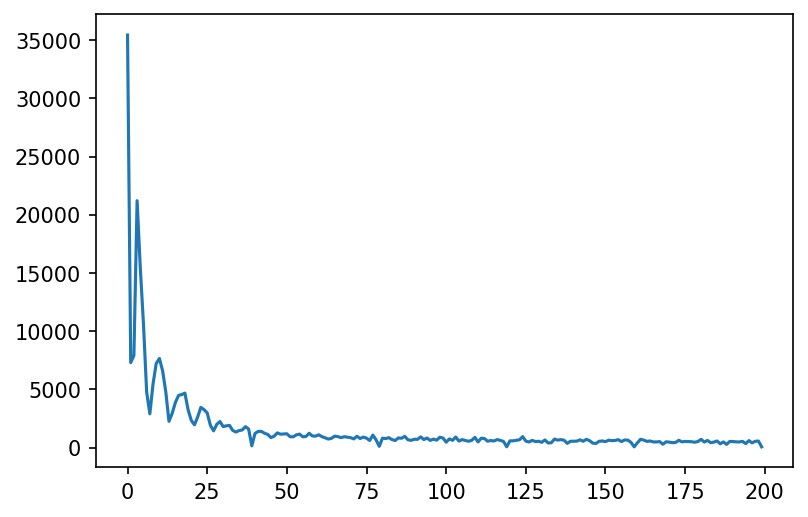

In [91]:
def create_model(dataset):
    D_in = dataset.dimensions
    model = torch.nn.Sequential(torch.nn.Linear(D_in, 1))
    model = model.to("cuda:0")
    return model


def train_model(model, loader, learning_rate: float = 1e-2):
    loss_fn = torch.nn.MSELoss(reduction="sum")

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #  TRAIN
    losses = []
    for epoch in range(5):
        for (basin, time), data in loader:
            X, y = data
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            # train/update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.detach().cpu().numpy())
            
    return model, losses
            
            
model = create_model(dataset)
model, losses = train_model(model, loader)

plt.plot(losses)

In [92]:
def to_xarray(predictions) -> xr.Dataset:
    return pd.DataFrame(predictions).set_index(["time", "station_id"]).to_xarray()
    

def calculate_predictions(model, loader):
    from collections import defaultdict

    predictions = defaultdict(list)

    with torch.no_grad():
        for (basin, time), data in loader:
            X, y = data
            y_hat = model(X)
            predictions["time"].extend(pd.to_datetime(time))
            predictions["station_id"].extend(basin)
            predictions["y_hat"].extend(y_hat.detach().cpu().numpy().flatten())
            predictions["y"].extend(y.detach().cpu().numpy().flatten())
            
    return to_xarray(predictions)

preds = calculate_predictions(model, loader)

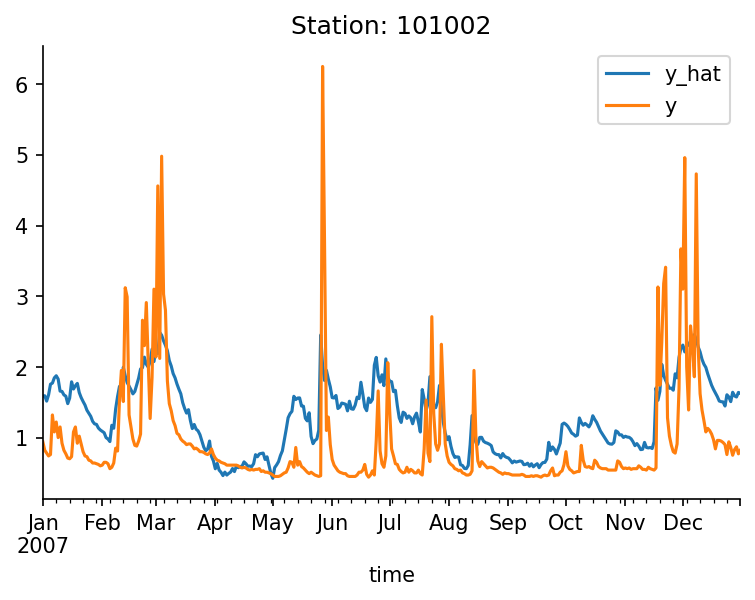

In [98]:
# DISCHARGE
# station = 10003; year = 2004
# station = 10003; year = 1998
# SOIL MOISTURE
# station = 10003; year = 2005
# # station = 10002; year = 2004

f, ax = plt.subplots()
station = np.random.choice(preds.station_id.values)
year = np.random.choice(np.unique(preds["time.year"]))

output.sel(station_id=station, time=slice(f"{year}", f"{year}")).to_dataframe().plot(ax=ax)
ax.set_title(f"Station: {station}")
ax.legend()
sns.despine()

In [103]:
output["doy"] = output["time.dayofyear"]
climatology = output.groupby("doy").mean()

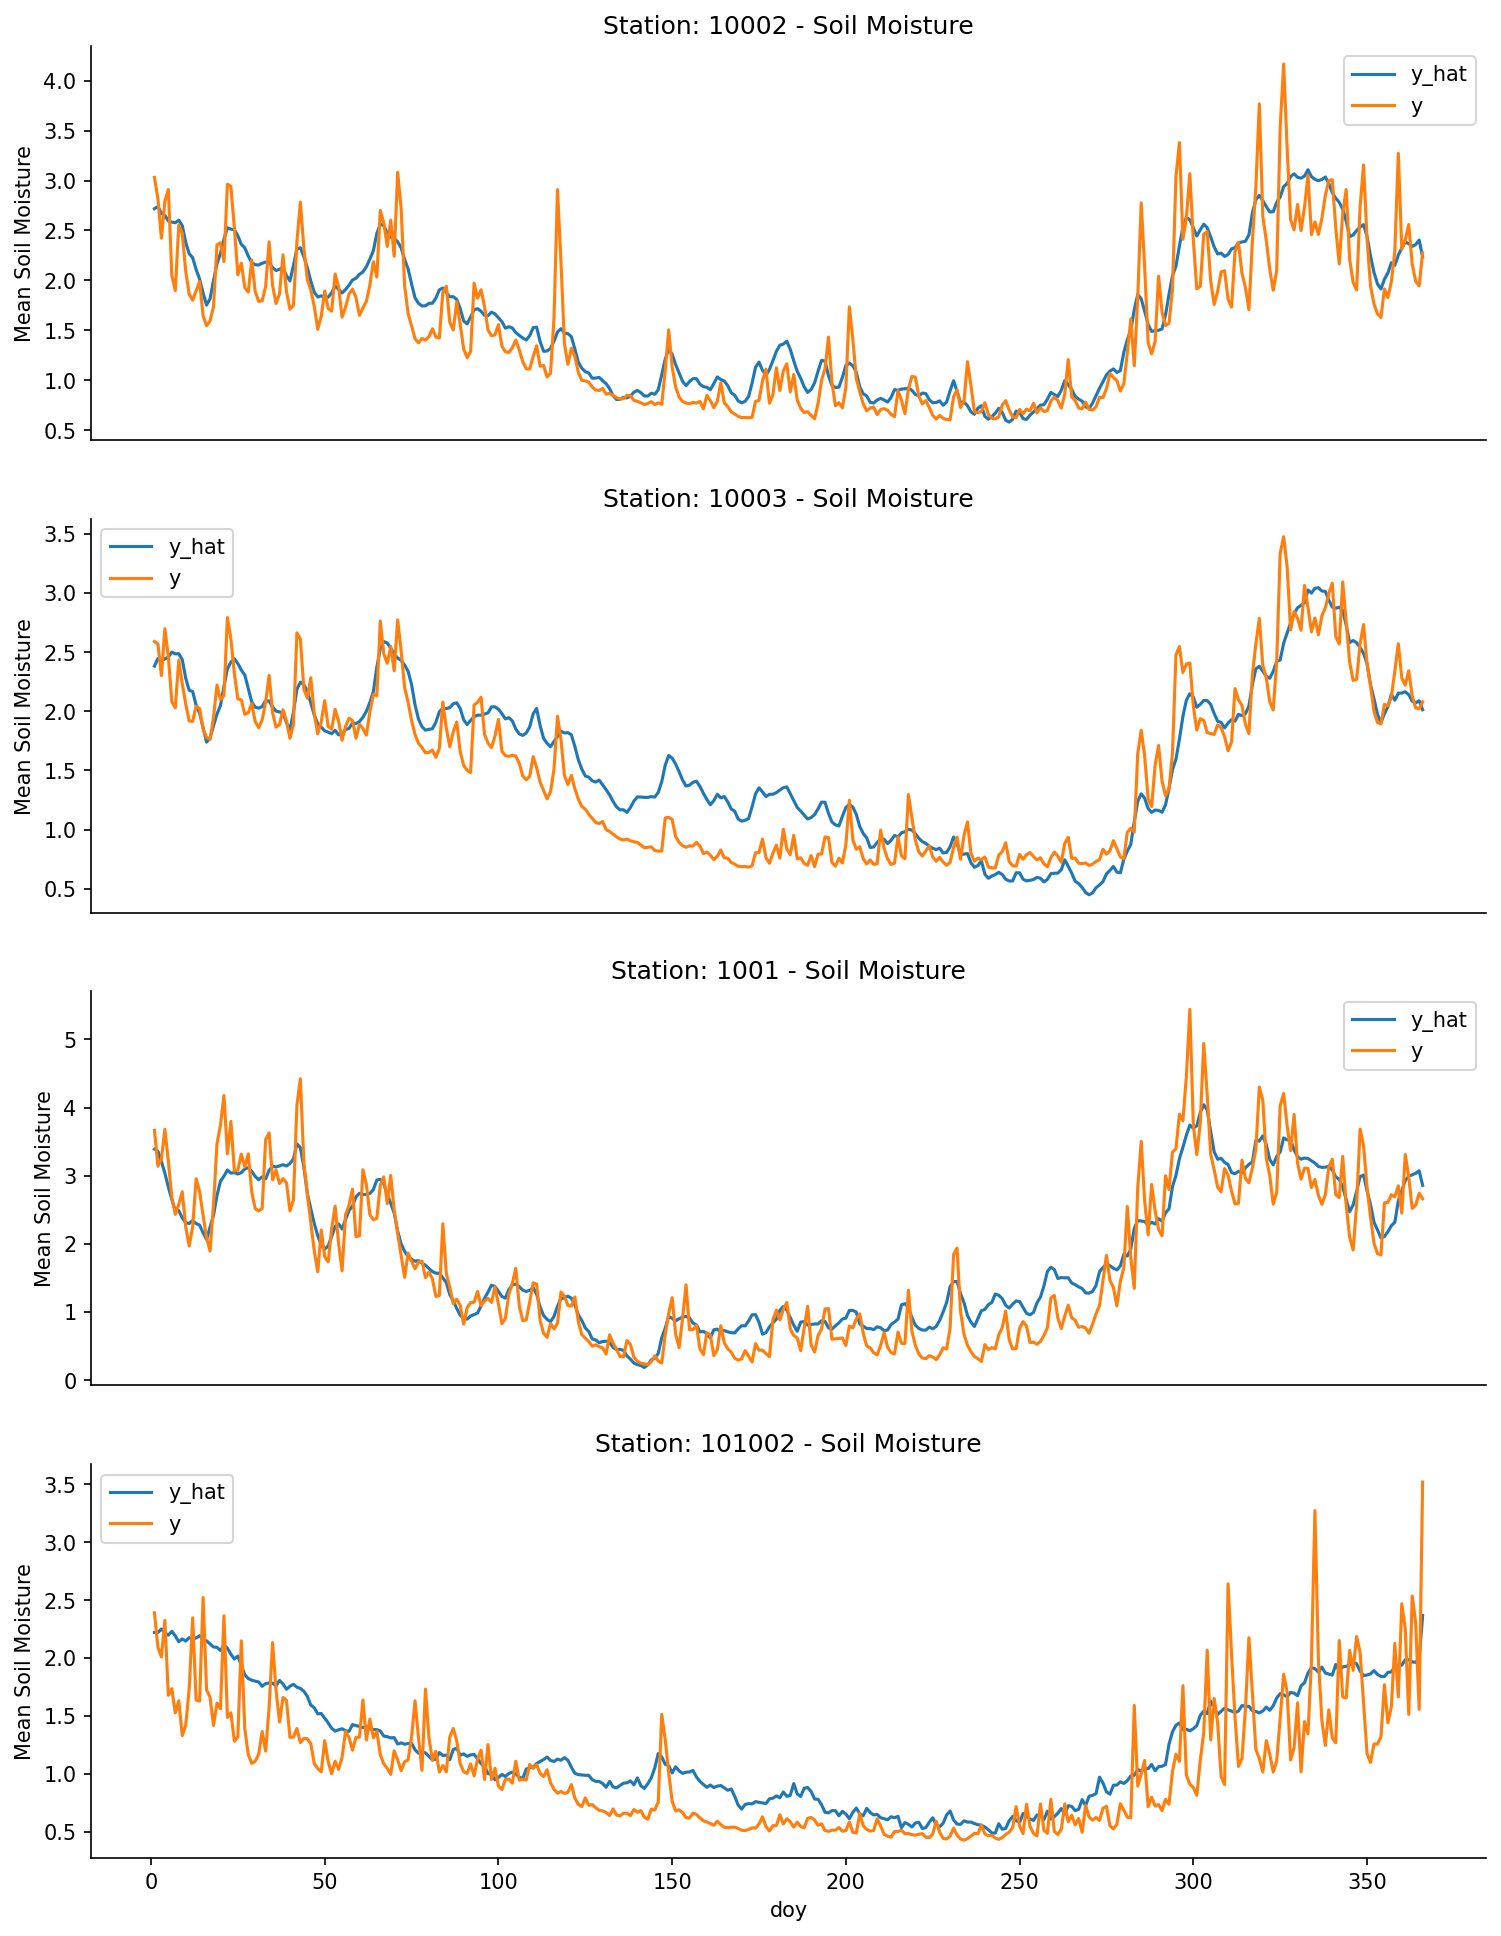

In [113]:
fig, axs = plt.subplots(len(climatology.station_id.values),1, figsize=(12, 4*len(climatology.station_id.values)))

for ix, station in enumerate(climatology.station_id.values):
    ax = axs[ix]
    d = climatology.sel(station_id=station).to_dataframe()
    d.plot(ax=ax)
    ax.set_title(f"Station: {station} - Soil Moisture")
    ax.set_ylabel("Mean Soil Moisture")
    sns.despine()
    if ix != len(climatology.station_id.values) - 1:
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_xlabel("")